# Video Data Preparation

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import scipy

### Paths

In [2]:
# Video features dataset
input_path = '../../1.feature_extraction/out/video/csv/'

# CSV output
output_path = '../out/video/'

# Global configuration path
glob_conf_path = '../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

## Concatenate all csv files

In [4]:
csv_paths = glob(input_path + '*.csv')
print("Files found:",len(csv_paths))

Files found: 1260


In [5]:
df = pd.DataFrame()  # Initialize empty data frame
for f in tqdm(csv_paths):
    df_tmp = pd.read_csv(f)
    
    file_name  = Path(f).stem    # Get file name without extention
    actor_id   = file_name[6:8]  # Get actor number id
    emotion_id = file_name[8:11] # Get emotion id
    _          = file_name[11:]  # Get number after emotion
    
    df_tmp['actor_id']   = actor_id                          # Add actor id to the df
    df_tmp['emotion_id'] = emotion_id                        # Add emotion id to the df
    df_tmp['emotion']    = emotion_id_to_emotion[emotion_id] # Add emotion to the df
    df_tmp['file']       = Path(f).name                      # Add file name to the df
    
    df = df.append(df_tmp)
    
df["file_id"] = pd.factorize(df.file, sort=True)[0]  # Add a column with a file id (number)
df.sort_values(by=['file_id'], ignore_index=True, inplace=True)

# When I started analyzing the data I realized that some column names have a whitespace at the beggining
# If you want to check it uncomment the following line
# print(df.columns)
df.columns = df.columns.str.lstrip() # Remove column name whitespaces 
df.to_csv(output_path + 'video_data_step_0_full_dataset.csv', index=None, header=True)

# Save mapping from video file to file id
df_files = df[['file_id','file']].drop_duplicates()
df_files.to_csv(output_path + 'video_data_step_0_file_id_mapping.csv', index=None, header=True)

100%|██████████| 1260/1260 [14:17<00:00,  1.47it/s]


In [6]:
df

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,actor_id,emotion_id,emotion,file,file_id
0,36,0,1.40,0.98,1,0.080399,0.175052,-0.981271,-0.050983,0.114144,...,0.0,0.0,0.0,0.0,0.0,01,amu,amusement,norm_A01amu111.csv,0
1,13,0,0.48,0.98,1,0.113539,0.194582,-0.974293,-0.194235,0.174355,...,0.0,0.0,0.0,0.0,0.0,01,amu,amusement,norm_A01amu111.csv,0
2,14,0,0.52,0.98,1,0.067272,0.194517,-0.978590,-0.213519,0.172747,...,0.0,0.0,0.0,0.0,0.0,01,amu,amusement,norm_A01amu111.csv,0
3,15,0,0.56,0.98,1,0.016583,0.159669,-0.987031,-0.197216,0.170438,...,0.0,0.0,0.0,0.0,0.0,01,amu,amusement,norm_A01amu111.csv,0
4,16,0,0.60,0.93,1,0.054239,0.148375,-0.987443,-0.200509,0.154192,...,0.0,0.0,0.0,0.0,0.0,01,amu,amusement,norm_A01amu111.csv,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76607,32,0,1.24,0.98,1,0.086852,0.126832,-0.988115,-0.107713,0.154966,...,0.0,0.0,0.0,0.0,0.0,10,tri,sadness,norm_A10tri419.csv,1259
76608,31,0,1.20,0.98,1,0.078189,0.120940,-0.989576,-0.105523,0.161119,...,0.0,0.0,0.0,0.0,0.0,10,tri,sadness,norm_A10tri419.csv,1259
76609,30,0,1.16,0.98,1,0.040860,0.106408,-0.993483,-0.101682,0.158917,...,0.0,0.0,0.0,0.0,0.0,10,tri,sadness,norm_A10tri419.csv,1259
76610,43,0,1.68,0.98,1,0.052226,0.144266,-0.988160,-0.074346,0.145329,...,0.0,0.0,0.0,0.0,0.0,10,tri,sadness,norm_A10tri419.csv,1259


## Data cleaning

### Data inspection before data cleaning
In this section we will inspect the dataset. For this porpuse, we will focus on the following elements:
* Number of instances per file
* Number of instances per actor
* Number of instances per emotion
* Number of instances per confidence rate
* Percentage of instances per confidence rate
* Number of files per emotion and actor

Where:
* Success: is the track successful (is there a face in the frame or do we think we tracked it well). Values are either 0 or 1.
* Confidence: how confident is the tracker in current landmark detection estimate. Values are between 0 and 1.

In [4]:
# Load csv
df = pd.read_csv(output_path + 'video_data_step_0_full_dataset.csv')

Total number of instances: 76612

Number of Instances per File (before data cleaning)
635     213
478     201
1104    194
1077    180
920     174
       ... 
119      17
593      16
118      15
592      14
898      13
Name: file_id, Length: 1260, dtype: int64



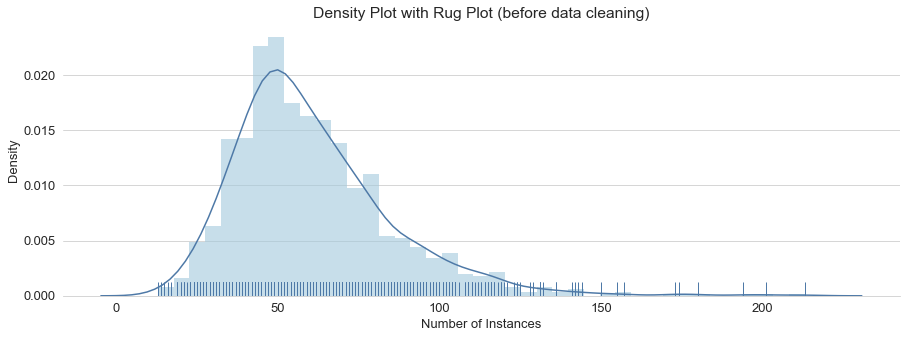


Number of Instances per Actor (before data cleaning)
3     9511
5     8628
6     8154
2     7990
7     7849
9     7694
10    7633
4     6824
8     6466
1     5863
Name: actor_id, dtype: int64


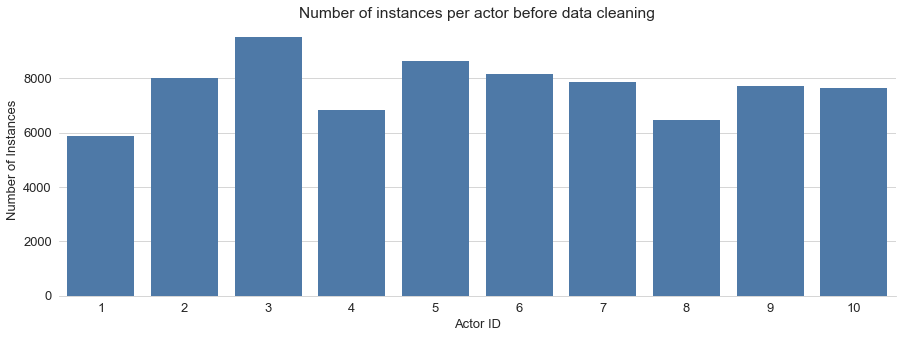


Number of Instances per Emotion (before data cleaning)
pla    6933
irr    6193
tri    5859
des    5825
sou    5786
amu    5424
joi    5406
int    5381
col    4892
fie    4842
inq    4447
peu    4042
adm    2271
mep    2127
hon    2043
att    1980
deg    1768
sur    1393
Name: emotion_id, dtype: int64


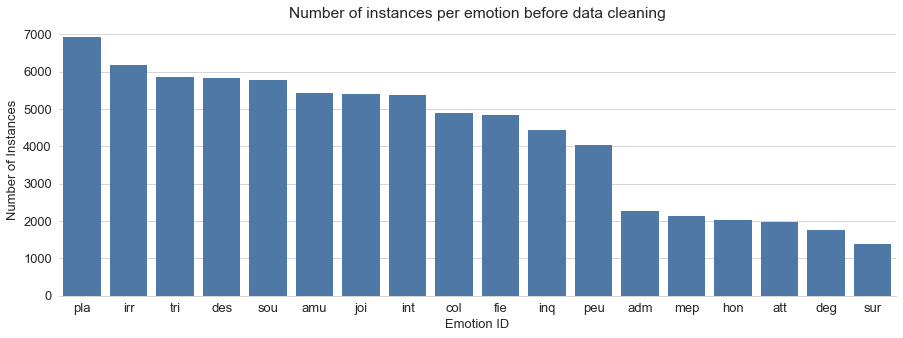


Number of Instances per Success Status (before data cleaning)
1    76164
0      448
Name: success, dtype: int64


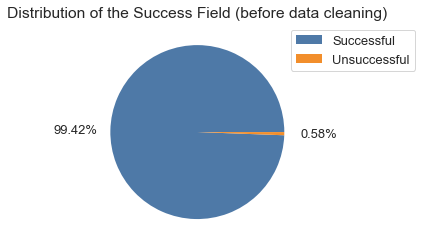


Percentage of Instances per Confidence Rate (before data cleaning)
0.00    0.004699
0.03    0.000979
0.17    0.000013
0.22    0.000013
0.32    0.000013
0.38    0.000013
0.43    0.000026
0.47    0.000026
0.52    0.000013
0.62    0.000013
0.68    0.000026
0.73    0.000065
0.77    0.000627
0.82    0.001005
0.88    0.014149
0.93    0.077729
0.98    0.900590
Name: confidence, dtype: float64


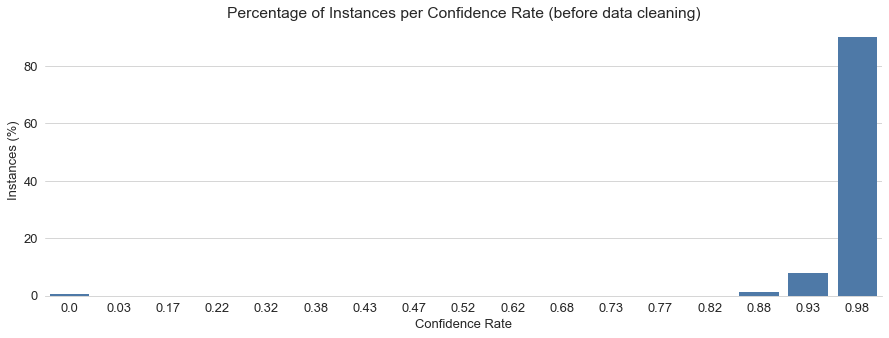


Number of Files per Emotion ID and Actor ID (before data cleaning)



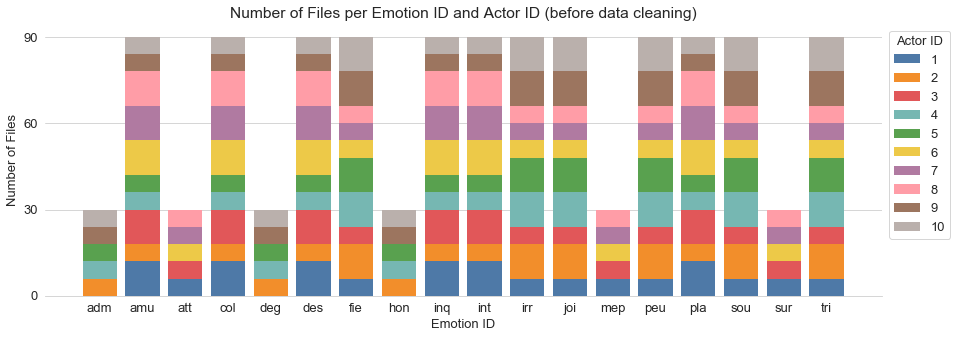

In [8]:
print("Total number of instances: {}".format(len(df)))
print()


print("Number of Instances per File (before data cleaning)")
file_val_counts_original = df["file_id"].value_counts()
print(file_val_counts_original)
print()


x = file_val_counts_original.values
plt.figure(figsize=(15,5))
sns.distplot(x, rug=True, norm_hist=True,
             rug_kws={'color': blue_shades[0],'alpha':1},
             kde_kws={'color': blue_shades[0],'alpha':1},
             hist_kws={'color': blue_shades[1], 'alpha':0.6}
            )
plt.xlabel('Number of Instances')
plt.ylabel('Density')
plt.grid(False,axis='x')
plt.savefig(os.path.join(output_path,'charts','report_distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.title('Density Plot with Rug Plot (before data cleaning)')
plt.savefig(os.path.join(output_path,'charts','distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Number of Instances per Actor (before data cleaning)")
actor_val_counts_original = df["actor_id"].value_counts()
print(actor_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(actor_val_counts_original.index, actor_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per actor before data cleaning")
plt.xlabel('Actor ID')
plt.ylabel('Number of Instances')
plt.show()
print()


print("Number of Instances per Emotion (before data cleaning)")
emotion_val_counts_original = df["emotion_id"].value_counts()
print(emotion_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(emotion_val_counts_original.index, emotion_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per emotion before data cleaning")
plt.xlabel('Emotion ID')
plt.ylabel('Number of Instances')
#plt.xticks(rotation=45)
plt.show()
print()


print("Number of Instances per Success Status (before data cleaning)")
success_val_counts_original = df["success"].value_counts()
print(success_val_counts_original)
plt.figure()
plt.pie(success_val_counts_original.values, autopct='%1.2f%%', pctdistance= 1.4, colors=palette_def)
plt.legend(['Successful','Unsuccessful'],bbox_to_anchor=(0.9, 1))
plt.savefig(os.path.join(output_path,'charts','report_success_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Distribution of the Success Field (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','success_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Percentage of Instances per Confidence Rate (before data cleaning)")
confidence_val_counts_original = df["confidence"].value_counts(normalize=True).sort_index()
print(confidence_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(confidence_val_counts_original.index, 100*confidence_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.xlabel('Confidence Rate')
plt.ylabel('Instances (%)')
plt.savefig(os.path.join(output_path,'charts','report_confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Percentage of Instances per Confidence Rate (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

print('Number of Files per Emotion ID and Actor ID (before data cleaning)')
data = df[['emotion_id','actor_id','file']].groupby(["actor_id",'emotion_id']).file.nunique().reset_index()
plt.figure(figsize=(15, 5))
bottom = np.zeros(18)
for n in data.actor_id.unique():
    data_tmp = data.loc[data['actor_id']==n]
    for emo in data.emotion_id.unique():
        if emo not in data_tmp.emotion_id.unique():
            data_tmp = data_tmp.append({'actor_id':n, 'emotion_id':emo, 'file':0}, ignore_index=True).sort_values(by='emotion_id',ignore_index=True)
    plt.bar(data_tmp['emotion_id'], data_tmp['file'], color=palette_def[n-1], bottom=bottom)
    bottom += data_tmp.file.values
plt.grid(False,axis='x')
plt.xlabel('Emotion ID')
plt.ylabel('Number of Files')
plt.yticks(np.arange(0, 100, step=30))
plt.legend(data.actor_id.unique(),title='Actor ID', bbox_to_anchor=(1.09, 1))
plt.savefig(os.path.join(output_path,'charts','report_number_files_per_emotion_actor_before_cleaning.svg'), bbox_inches = 'tight')
plt.title('Number of Files per Emotion ID and Actor ID (before data cleaning)')
plt.savefig(os.path.join(output_path,'charts','number_files_per_emotion_actor_before_cleaning.svg'), bbox_inches = 'tight')
print()

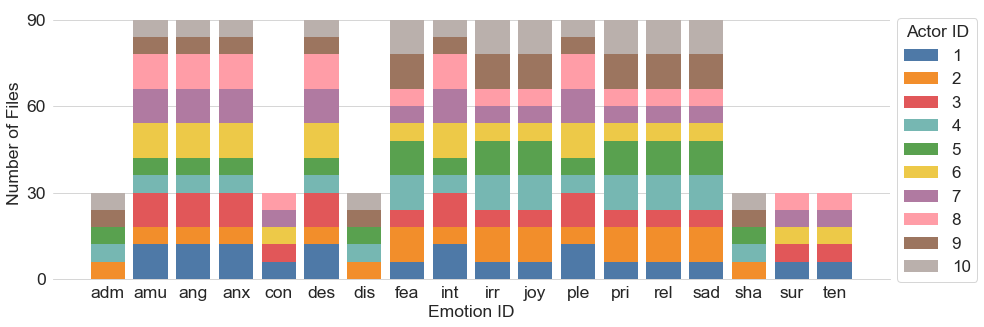

In [5]:
#print('Number of Files per Emotion ID and Actor ID (before data cleaning)')
matplotlib.rcParams.update({'font.size': 17.5})
data = df[['emotion_id','actor_id','file']].groupby(["actor_id",'emotion_id']).file.nunique().reset_index()
data['emotion_id'] = data['emotion_id'].map(emotion_fr_id_to_emotion_eng_id)
plt.figure(figsize=(15, 5))
bottom = np.zeros(18)
for n in data.actor_id.unique():
    data_tmp = data.loc[data['actor_id']==n]
    for emo in data.emotion_id.unique():
        if emo not in data_tmp.emotion_id.unique():
            data_tmp = data_tmp.append({'actor_id':n, 'emotion_id':emo, 'file':0}, ignore_index=True).sort_values(by='emotion_id',ignore_index=True)
    plt.bar(data_tmp['emotion_id'], data_tmp['file'], color=palette_def[n-1], bottom=bottom)
    bottom += data_tmp.file.values
plt.grid(False,axis='x')
plt.xlabel('Emotion ID')
plt.ylabel('Number of Files')
plt.yticks(np.arange(0, 100, step=30))
plt.legend(data.actor_id.unique(),title='Actor ID', fontsize=17, bbox_to_anchor=(1.115, 0.99))
#plt.legend(data.actor_id.unique(),title='Actor ID', fontsize=17, bbox_to_anchor=(0.96, 0.99))
plt.savefig(os.path.join(output_path,'charts','report_number_files_per_emotion_actor_before_cleaning_2.svg'), bbox_inches = 'tight')
#plt.title('Number of Files per Emotion ID and Actor ID (before data cleaning)')
#plt.savefig(os.path.join(output_path,'charts','number_files_per_emotion_actor_before_cleaning.svg'), bbox_inches = 'tight')
print()

### Data cleaning process
In this section, we will clean the dataset. For this purpose, we will remove those instances that do not satisfy the following two conditions:
* Success == 1
* Confidence rate >= 0.98

In [18]:
print("Number of Instances per Actor (before data cleaning)")
actor_val_counts_original = df[['actor_id','file']].groupby(["actor_id"]).file.nunique().reset_index()
print(actor_val_counts_original)
print()

Number of Instances per Actor (before data cleaning)
   actor_id  file
0         1   126
1         2   126
2         3   126
3         4   126
4         5   126
5         6   126
6         7   126
7         8   126
8         9   126
9        10   126



In [9]:
# Load csv
df = pd.read_csv(output_path + 'video_data_step_0_full_dataset.csv')

In [10]:
confidence_th = 0.98 

df_tmp = pd.DataFrame()
rows_tmp = [r for index,r in df.iterrows() if (r["success"] == 1 and r["confidence"] >= confidence_th)]
df_tmp = pd.DataFrame(rows_tmp)

df_tmp.to_csv(output_path + 'video_data_step_1_cleaned_dataset.csv', index=None, header=True)

### Data inspection after data cleaning

In [12]:
# Load full data set csv (before data cleaning)
df = pd.read_csv(output_path + 'video_data_step_0_full_dataset.csv')
# Load cleaned dataset csv
df_cl = pd.read_csv(output_path + 'video_data_step_1_cleaned_dataset.csv')

print('Number of instances before data cleaning: {}'.format(len(df)))
print('Number of instances after data cleaning: {}'.format(len(df_cl)))

print('Number of files before data cleaning: {}'.format(df.file.nunique()))
print('Number of files after data cleaning: {}'.format(df_cl.file.nunique()))

# List deleted files
files_df = list(df['file'].astype('category').cat.categories)
files_df_cl = list(df_cl['file'].astype('category').cat.categories)
deleted_files = []
for f in files_df:
    if f not in files_df_cl:
        deleted_files.append(f)
print('Deleted files: {}'.format(', '.join(deleted_files)))

print("The number of instances has decreased by {:.2f}% after the cleaning process.".format((len(df)-len(df_cl))*100/len(df)))

Number of instances before data cleaning: 76612
Number of instances after data cleaning: 68996
Number of files before data cleaning: 1260
Number of files after data cleaning: 1259
Deleted files: norm_A05int132.csv
The number of instances has decreased by 9.94% after the cleaning process.


As we can see, one file has been deleted (because all the instances from that file did not satisfy the success or confidence rate). We have to keep this in mind for the early fusion approach.

Total number of instances: 68996

Number of instances per file after data cleaning
635     202
478     201
610     157
533     153
785     151
       ... 
539       9
395       5
23        3
1109      2
22        2
Name: file_id, Length: 1259, dtype: int64



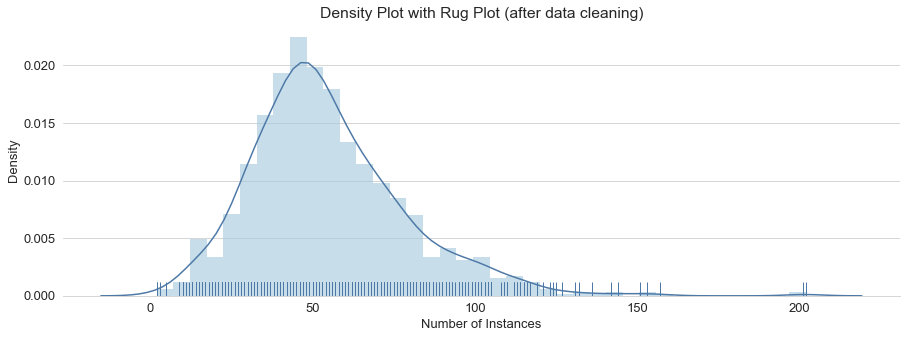


Number of Instances per Actor (after data cleaning)
3     8447
2     7768
6     7507
5     7402
10    7182
7     7046
4     6621
9     6189
8     5499
1     5335
Name: actor_id, dtype: int64


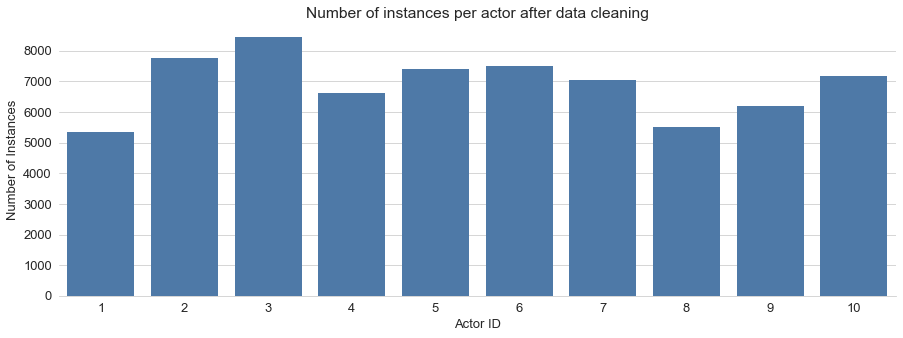


Number of Instances per Emotion (after data cleaning)
pla    5979
tri    5718
irr    5568
sou    5396
des    5253
int    5137
amu    4393
joi    4371
inq    4315
fie    4215
col    3881
peu    3744
adm    2150
mep    2054
att    1933
hon    1903
deg    1719
sur    1267
Name: emotion_id, dtype: int64


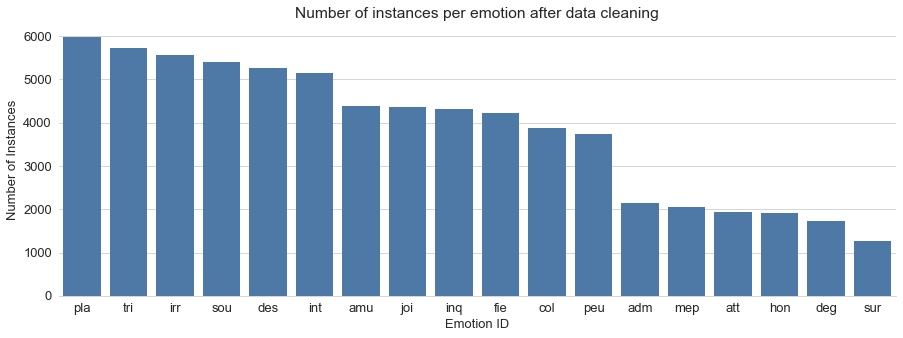


Number of Instances per Success Status (after data cleaning)
1    68996
Name: success, dtype: int64


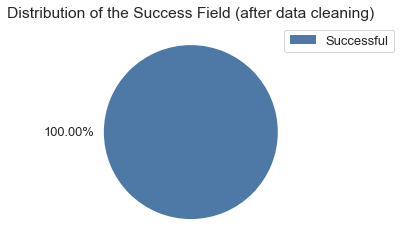


Percentage of Instances per Confidence Rate (after data cleaning)
0.98    1.0
Name: confidence, dtype: float64


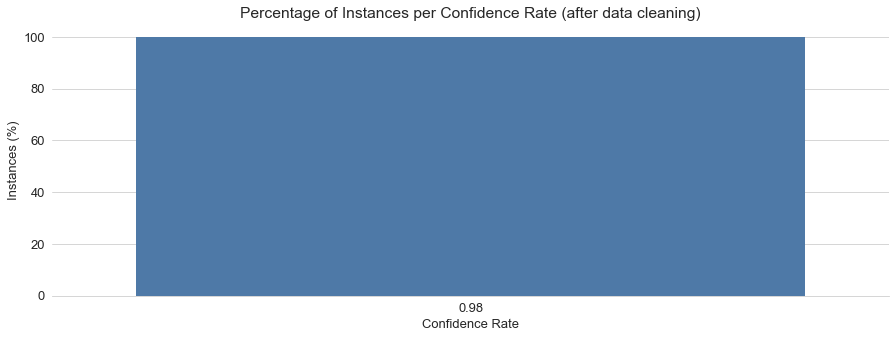


Number of Files per Emotion ID and Actor ID (after data cleaning)



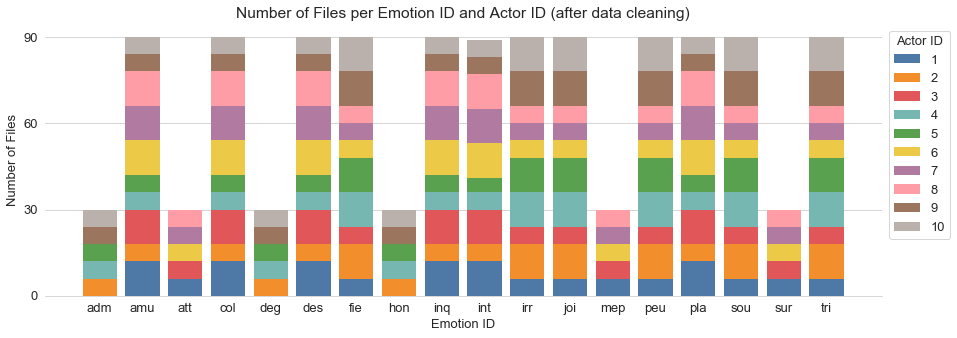

In [13]:
print("Total number of instances: {}".format(len(df_cl)))
print()


print("Number of instances per file after data cleaning")
file_val_counts_original = df_cl["file_id"].value_counts()
print(file_val_counts_original)
print()


x = file_val_counts_original.values
plt.figure(figsize=(15,5))
sns.distplot(x, rug=True, norm_hist=True,
             rug_kws={'color': blue_shades[0],'alpha':1},
             kde_kws={'color': blue_shades[0],'alpha':1},
             hist_kws={'color': blue_shades[1], 'alpha':0.6}
            )
plt.xlabel('Number of Instances')
plt.ylabel('Density')
plt.grid(False,axis='x')
plt.savefig(os.path.join(output_path,'charts','report_distribution_after_cleaning.svg'), bbox_inches = 'tight')
plt.title('Density Plot with Rug Plot (after data cleaning)')
plt.savefig(os.path.join(output_path,'charts','distribution_after_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Number of Instances per Actor (after data cleaning)")
actor_val_counts_original = df_cl["actor_id"].value_counts()
print(actor_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(actor_val_counts_original.index, actor_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per actor after data cleaning")
plt.xlabel('Actor ID')
plt.ylabel('Number of Instances')
plt.show()
print()


print("Number of Instances per Emotion (after data cleaning)")
emotion_val_counts_original = df_cl["emotion_id"].value_counts()
print(emotion_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(emotion_val_counts_original.index, emotion_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per emotion after data cleaning")
plt.xlabel('Emotion ID')
plt.ylabel('Number of Instances')
#plt.xticks(rotation=45)
plt.show()
print()


print("Number of Instances per Success Status (after data cleaning)")
success_val_counts_original = df_cl["success"].value_counts()
print(success_val_counts_original)
plt.figure()
plt.pie(success_val_counts_original.values, autopct='%1.2f%%', pctdistance= 1.4, colors=palette_def)
plt.legend(['Successful','Unsuccessful'],bbox_to_anchor=(0.9, 1))
plt.savefig(os.path.join(output_path,'charts','report_success_after_cleaning.svg'), bbox_inches = 'tight')
plt.title("Distribution of the Success Field (after data cleaning)")
plt.savefig(os.path.join(output_path,'charts','success_after_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Percentage of Instances per Confidence Rate (after data cleaning)")
confidence_val_counts_original = df_cl["confidence"].value_counts(normalize=True).sort_index()
print(confidence_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(confidence_val_counts_original.index, 100*confidence_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.xlabel('Confidence Rate')
plt.ylabel('Instances (%)')
plt.savefig(os.path.join(output_path,'charts','report_confidence_after_cleaning.svg'), bbox_inches = 'tight')
plt.title("Percentage of Instances per Confidence Rate (after data cleaning)")
plt.savefig(os.path.join(output_path,'charts','confidence_after_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

print('Number of Files per Emotion ID and Actor ID (after data cleaning)')
data = df_cl[['emotion_id','actor_id','file']].groupby(["actor_id",'emotion_id']).file.nunique().reset_index()
plt.figure(figsize=(15, 5))
bottom = np.zeros(18)
for n in data.actor_id.unique():
    data_tmp = data.loc[data['actor_id']==n]
    for emo in data.emotion_id.unique():
        if emo not in data_tmp.emotion_id.unique():
            data_tmp = data_tmp.append({'actor_id':n, 'emotion_id':emo, 'file':0}, ignore_index=True).sort_values(by='emotion_id',ignore_index=True)
    plt.bar(data_tmp['emotion_id'], data_tmp['file'], color=palette_def[n-1], bottom=bottom)
    bottom += data_tmp.file.values
plt.grid(False,axis='x')
plt.xlabel('Emotion ID')
plt.ylabel('Number of Files')
plt.yticks(np.arange(0, 100, step=30))
plt.legend(data.actor_id.unique(),title='Actor ID', bbox_to_anchor=(1.09, 1))
plt.savefig(os.path.join(output_path,'charts','report_number_files_per_emotion_actor_after_cleaning.svg'), bbox_inches = 'tight')
plt.title('Number of Files per Emotion ID and Actor ID (after data cleaning)')
plt.savefig(os.path.join(output_path,'charts','number_files_per_emotion_actor_after_cleaning.svg'), bbox_inches = 'tight')
print()

## Dimensionality reduction
In this section, we will reduce the dimensionality of our dataset by manually selecting relevant features for our sample (feature selection). But first, we will see what kinds of dimensions we have in the dataset.

In [5]:
# Load cleaned dataset
df_cl = pd.read_csv(output_path + 'video_data_step_1_cleaned_dataset.csv')

As we can see in the following output, face_id can be deleted since all the instances have 0 as a value.

In [6]:
df_cl["face_id"].value_counts()

0    68996
Name: face_id, dtype: int64

As we can see in the following output, there is no AU28_r (intensity of lip sucking). 

In [7]:
AU_cols = [col for col in df_cl if col.startswith('AU')]
AU_presence_cols = [col for col in AU_cols if col.endswith('c')] 
AU_intensity_cols = [col for col in AU_cols if col.endswith('r')] 
print(AU_presence_cols)
print(AU_intensity_cols)

['AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c']
['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']


In [8]:
other_wanted_cols = ['emotion_id', 'file_id', 'actor_id']

# Create datasets
df_presence = df_cl[AU_presence_cols+other_wanted_cols]
df_presence.to_csv(output_path + 'video_data_step_2_presence.csv', index=None, header=True)


df_intensity = df_cl[AU_intensity_cols+other_wanted_cols]
df_intensity.to_csv(output_path + 'video_data_step_2_intensity.csv', index=None, header=True)

In [5]:
# Load cleaned dataset
df_cl = pd.read_csv(output_path + 'video_data_step_1_cleaned_dataset.csv')
non_feauture_columns = ['frame', 'face_id', 'timestamp', 'confidence', 'success', 'actor_id', 'emotion_id', 'emotion', 'file', 'file_id']
num_features_original = len(df_cl.drop(non_feauture_columns, axis=1).columns)
print("Original number of features: {}".format(num_features_original))

# Load reduced dataset (AU_presence)
df_presence = pd.read_csv(output_path + 'video_data_step_2_presence.csv')
non_feauture_columns = ['emotion_id', 'file_id']
num_features_AU_presence = len(df_presence.drop(non_feauture_columns, axis=1).columns)
print("Number of features (AU_presence): {}".format(num_features_AU_presence))

# Load reduced dataset (AU_intensity)
df_intensity = pd.read_csv(output_path + 'video_data_step_2_intensity.csv')
non_feauture_columns = ['emotion_id', 'file_id', 'actor_id']
num_features_AU_intensity = len(df_intensity.drop(non_feauture_columns, axis=1).columns)
print("Number of features (AU_intensity): {}".format(num_features_AU_intensity))

Original number of features: 709
Number of features (AU_presence): 19
Number of features (AU_intensity): 17


In [6]:
df_intensity = pd.read_csv(output_path + 'video_data_step_2_intensity.csv')
df_intensity

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,emotion_id,file_id,actor_id
0,0.00,0.00,0.19,0.01,2.00,1.51,0.12,2.53,1.45,0.22,0.00,0.75,0.00,0.00,1.78,0.44,0.22,amu,0,1
1,1.11,0.71,0.00,0.00,1.91,1.18,0.00,2.50,1.89,0.54,0.48,0.21,0.08,0.00,2.45,0.69,0.61,amu,0,1
2,1.13,0.81,0.00,0.01,1.82,1.08,0.00,2.36,1.68,0.63,0.50,0.53,0.19,0.04,1.31,0.74,0.55,amu,0,1
3,1.15,0.85,0.00,0.01,1.76,1.05,0.00,2.32,1.47,0.62,0.51,1.08,0.12,0.30,0.45,0.51,0.37,amu,0,1
4,0.82,0.37,0.06,0.05,1.63,1.36,0.00,1.98,1.12,0.60,0.62,1.56,0.00,0.33,0.18,0.81,0.41,amu,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68991,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.33,0.01,0.00,0.04,0.00,0.22,tri,1259,10
68992,0.06,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.30,0.42,0.01,0.00,0.04,0.00,0.23,tri,1259,10
68993,0.04,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.23,0.39,0.00,0.04,0.00,0.00,0.45,tri,1259,10
68994,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.10,0.18,0.00,0.74,0.39,0.00,tri,1259,10


## From time series data to average features
OpenFace returns multiple instances per video file, whereas openSMILE just returns one instance per file. Since we need data consistency between modalities, we decided to average video features.

In [6]:
from scipy.signal import find_peaks

def my_find_peaks(x):
    th = x.mean()
    val = x.values
    peaks, _ = find_peaks(val, height=th)
    return len(peaks)

In [7]:
# Load reduced dataset (AU_intensity)
df_intensity = pd.read_csv(output_path + 'video_data_step_2_intensity.csv')
df_tmp = df_intensity.drop(columns=['emotion_id','actor_id'])

# Compute statistical measures 
df_tmp = df_tmp.groupby(['file_id']).agg(['mean',                                    # Arithmetic mean
                                          lambda x: scipy.stats.variation(x),        # Coefficient of variation
                                          lambda x: np.percentile(x, q=20),          # 20th percentile
                                          lambda x: np.percentile(x, q=50),          # 50th percentile
                                          lambda x: np.percentile(x, q=80),          # 80th percentile
                                          lambda x: scipy.stats.iqr(x, rng=(20,80)), # IQR(60%) = 80th percentile - 20th percentile
                                          lambda x: my_find_peaks(x),                # Number of peaks above the adaptive threshold
                                          ]).reset_index().sort_values(by=['file_id'], ignore_index=True)

# Rename columns
df_tmp.rename(columns={'<lambda_0>': 'stddevNorm',
                       '<lambda_1>': 'percentile20.0',
                       '<lambda_2>': 'percentile50.0',
                       '<lambda_3>': 'percentile80.0',
                       '<lambda_4>': 'iqr60_80-20',
                       '<lambda_5>': 'numPeaks',
                      }, level=1,inplace=True)

# Impute NaN values
# There might be some NaN values in the dataframe coming from the coefficient of variation (std(x)/mean(x) when mean(x)=0) 
df_tmp.fillna(0, inplace=True)


# Collapse hierarchical index in columns
df_tmp.columns = ['_'.join(col).strip('_') for col in df_tmp.columns.values]

# Add emotion_id and actor_id to the dataframe
metadata_df = df_intensity[['file_id','emotion_id','actor_id']].drop_duplicates()
df_tmp = pd.merge(df_tmp, metadata_df, on='file_id')

# Reorder columns
AU_cols = [col for col in df_tmp if col.startswith('AU')]
df_tmp = pd.concat([df_tmp[AU_cols],df_tmp[['emotion_id','actor_id','file_id']]], axis=1)
df_tmp.to_csv(output_path + 'video_data_step_3_mean_intensity.csv', index=None, header=True)
df_tmp

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,emotion_id,actor_id,file_id
0,0.321915,1.314782,0.0,0.000,0.846,0.846,7.0,0.107447,2.231391,0.0,...,0.120638,1.419086,0.0,0.01,0.260,0.260,8.0,amu,1,0
1,0.109355,1.428600,0.0,0.030,0.340,0.340,4.0,0.052581,1.752390,0.0,...,0.115484,2.280733,0.0,0.01,0.160,0.160,5.0,amu,1,1
2,0.159512,1.300061,0.0,0.030,0.390,0.390,8.0,0.088780,1.604777,0.0,...,0.076829,1.485273,0.0,0.04,0.110,0.110,3.0,amu,1,2
3,0.252121,1.233719,0.0,0.000,0.616,0.616,2.0,0.052121,1.675771,0.0,...,0.047879,1.183460,0.0,0.02,0.100,0.100,4.0,amu,1,3
4,0.302895,1.623174,0.0,0.000,0.618,0.618,5.0,0.095789,2.322240,0.0,...,0.097632,0.997891,0.0,0.08,0.180,0.180,7.0,amu,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.126170,1.053705,0.0,0.080,0.288,0.288,9.0,0.070638,1.930354,0.0,...,0.516383,1.401639,0.0,0.00,1.594,1.594,5.0,tri,10,1255
1255,0.064569,1.510803,0.0,0.030,0.100,0.100,15.0,0.038190,1.745952,0.0,...,0.227328,1.982144,0.0,0.03,0.300,0.300,8.0,tri,10,1256
1256,0.200735,1.855819,0.0,0.010,0.280,0.280,13.0,0.089706,2.423938,0.0,...,0.273897,2.153521,0.0,0.01,0.220,0.220,10.0,tri,10,1257
1257,0.104464,1.482538,0.0,0.015,0.250,0.250,6.0,0.036071,1.950244,0.0,...,0.346429,1.401757,0.0,0.00,0.920,0.920,7.0,tri,10,1258


In [8]:
df_tmp.isnull().values.any()

False

## Normalize training set

In [5]:
intensity_df = pd.read_csv(output_path + 'video_data_step_3_mean_intensity.csv')
intensity_df

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,emotion_id,actor_id,file_id
0,0.321915,1.314782,0.0,0.000,0.846,0.846,7.0,0.107447,2.231391,0.0,...,0.120638,1.419086,0.0,0.01,0.260,0.260,8.0,amu,1,0
1,0.109355,1.428600,0.0,0.030,0.340,0.340,4.0,0.052581,1.752390,0.0,...,0.115484,2.280733,0.0,0.01,0.160,0.160,5.0,amu,1,1
2,0.159512,1.300061,0.0,0.030,0.390,0.390,8.0,0.088780,1.604777,0.0,...,0.076829,1.485273,0.0,0.04,0.110,0.110,3.0,amu,1,2
3,0.252121,1.233719,0.0,0.000,0.616,0.616,2.0,0.052121,1.675771,0.0,...,0.047879,1.183460,0.0,0.02,0.100,0.100,4.0,amu,1,3
4,0.302895,1.623174,0.0,0.000,0.618,0.618,5.0,0.095789,2.322240,0.0,...,0.097632,0.997891,0.0,0.08,0.180,0.180,7.0,amu,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.126170,1.053705,0.0,0.080,0.288,0.288,9.0,0.070638,1.930354,0.0,...,0.516383,1.401639,0.0,0.00,1.594,1.594,5.0,tri,10,1255
1255,0.064569,1.510803,0.0,0.030,0.100,0.100,15.0,0.038190,1.745952,0.0,...,0.227328,1.982144,0.0,0.03,0.300,0.300,8.0,tri,10,1256
1256,0.200735,1.855819,0.0,0.010,0.280,0.280,13.0,0.089706,2.423938,0.0,...,0.273897,2.153521,0.0,0.01,0.220,0.220,10.0,tri,10,1257
1257,0.104464,1.482538,0.0,0.015,0.250,0.250,6.0,0.036071,1.950244,0.0,...,0.346429,1.401757,0.0,0.00,0.920,0.920,7.0,tri,10,1258


In [6]:
from sklearn import preprocessing

X = intensity_df.drop(columns=['emotion_id','file_id','actor_id'])              # Get features from training set
min_max_scaler = preprocessing.MinMaxScaler()                                   # Video min max scaler
X_scaled = min_max_scaler.fit_transform(X)                                      # Fit and transform features
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())          # Create a dataframe from normalized features
metadata_df = intensity_df[['emotion_id','actor_id','file_id']]
metadata_df = metadata_df.assign(target=metadata_df.loc[:,'emotion_id'].map(emotion_id_to_emotion_num).values)
metadata_df = metadata_df.drop(columns=['emotion_id'])
train_scaled_df = pd.concat([X_scaled_df,metadata_df], axis=1)
train_scaled_df

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,actor_id,file_id,target
0,0.130612,0.240045,0.0,0.000000,0.238713,0.238713,0.250000,0.141816,0.451565,0.0,...,0.090554,0.363398,0.0,0.007299,0.092857,0.092857,0.258065,1,0,1
1,0.044369,0.260825,0.0,0.009934,0.095937,0.095937,0.142857,0.069400,0.354630,0.0,...,0.086685,0.584047,0.0,0.007299,0.057143,0.057143,0.161290,1,1,1
2,0.064720,0.237358,0.0,0.009934,0.110045,0.110045,0.285714,0.117179,0.324758,0.0,...,0.057670,0.380347,0.0,0.029197,0.039286,0.039286,0.096774,1,2,1
3,0.102294,0.225245,0.0,0.000000,0.173815,0.173815,0.071429,0.068794,0.339125,0.0,...,0.035939,0.303059,0.0,0.014599,0.035714,0.035714,0.129032,1,3,1
4,0.122895,0.296350,0.0,0.000000,0.174379,0.174379,0.178571,0.126430,0.469950,0.0,...,0.073285,0.255539,0.0,0.058394,0.064286,0.064286,0.225806,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.051192,0.192379,0.0,0.026490,0.081264,0.081264,0.321429,0.093234,0.390645,0.0,...,0.387610,0.358930,0.0,0.000000,0.569286,0.569286,0.161290,10,1255,17
1255,0.026198,0.275834,0.0,0.009934,0.028217,0.028217,0.535714,0.050406,0.353327,0.0,...,0.170638,0.507585,0.0,0.021898,0.107143,0.107143,0.258065,10,1256,17
1256,0.081445,0.338825,0.0,0.003311,0.079007,0.079007,0.464286,0.118401,0.490531,0.0,...,0.205594,0.551471,0.0,0.007299,0.078571,0.078571,0.322581,10,1257,17
1257,0.042385,0.270673,0.0,0.004967,0.070542,0.070542,0.214286,0.047610,0.394670,0.0,...,0.260038,0.358960,0.0,0.000000,0.328571,0.328571,0.225806,10,1258,17


## Create groups for LOGO CV

In [7]:
import random

# Find random pairs of actors
random.seed(seed)
actors_1 = [2, 4, 5, 9, 10]
actors_2 = [1, 3, 6, 7, 8]
actors_2_shuffled = random.sample(actors_2, len(actors_2))

# Define groups
groups = {actors_1[0]: 1, actors_2_shuffled[0]: 1, # G1 = (A02, A07) (female, female)
          actors_1[1]: 2, actors_2_shuffled[1]: 2, # G2 = (A04, A06) (male, female)
          actors_1[2]: 3, actors_2_shuffled[2]: 3, # G3 = (A05, A03) (male, male)
          actors_1[3]: 4, actors_2_shuffled[3]: 4, # G4 = (A09, A01) (female, male)
          actors_1[4]: 5, actors_2_shuffled[4]: 5  # G5 = (A10, A08) (female, male)
         }
print(groups)

# Create a copy
train_scaled_groups_df = train_scaled_df.copy()

# Insert group column
train_scaled_groups_df['group'] = train_scaled_groups_df['actor_id'].map(groups)
train_scaled_groups_df.to_csv(output_path + 'video_data_intensity_train.csv', index=None, header=True)

{2: 1, 7: 1, 4: 2, 6: 2, 5: 3, 3: 3, 9: 4, 1: 4, 10: 5, 8: 5}
